In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
#for filter
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import freqz;
from scipy.signal import find_peaks
import scipy
from scipy import signal
import librosa
import librosa.display 
import os
import math
import latexify as lt
#%matplotlib notebook

In [2]:

def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y;

In [3]:
import scipy as sp
from scipy import signal

def emd(x, nIMF = 3, stoplim = .001):
    """Perform empirical mode decomposition to extract 'niMF' components out of the signal 'x'."""
    
    r = x
    t = np.arange(len(r))
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False
        
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]
            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)
            
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)
            
            # Calculate mean
            mean_t = (pks_t + trs_t) / 2
            mean_t = _emd_complim(mean_t, pks, trs)
            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, mean_t, pks, trs)
            
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - mean_t
                
        
        imfs[i] = r_t
        r = r - imfs[i] 
        
    return imfs


def _emd_comperror(h, mean, pks, trs):
    """Calculate the normalized error of the current component"""
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))


def _emd_complim(mean_t, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

hi
['Noise.2bb4gcf4.ingestion-5878c74f44-7lfkt.wav', 'Noise.2bvqadvo.ingestion-586d77bfd8-gx2n5.wav', 'Noise.Idle.2a9pllt1.ingestion-5bf4958dd5-jtgqv.wav', 'Noise.Idle.2a9png42.ingestion-5bf4958dd5-jtgqv.wav']
0.05439621629582022
0.11721230448599256
0.002927951596223121
0.004138494975520659


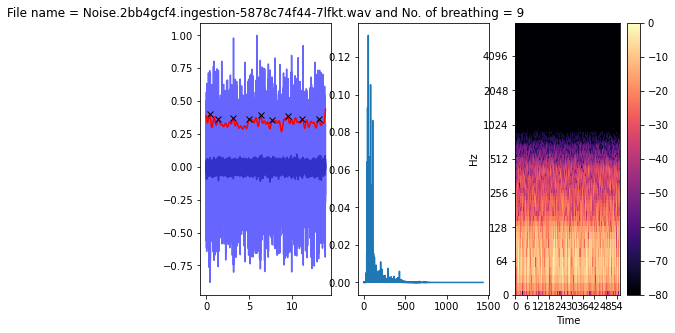

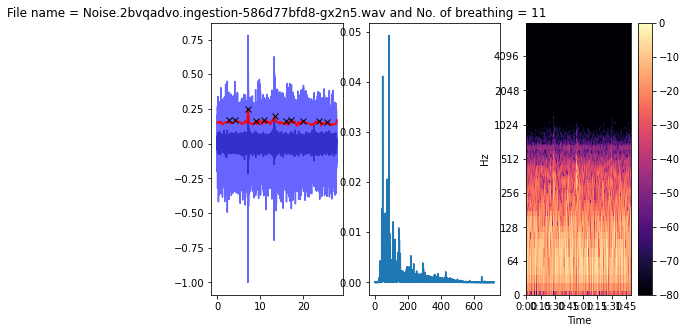

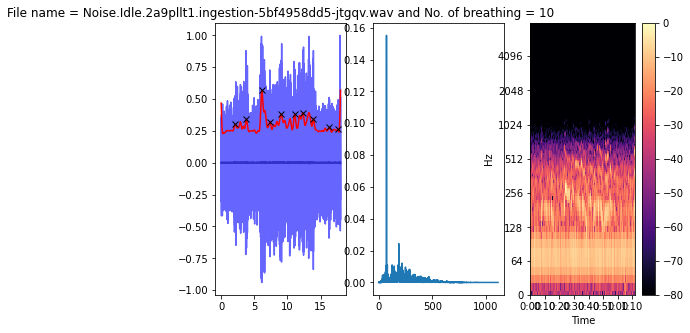

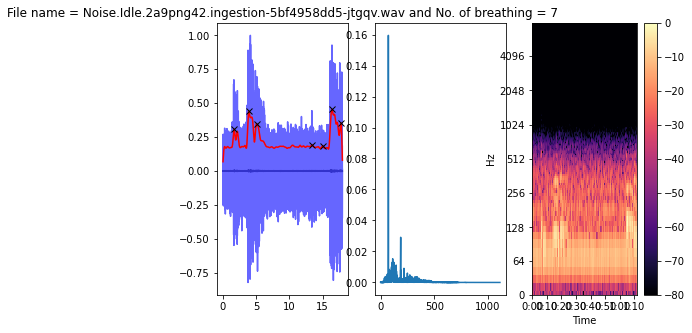

In [38]:
#now using hilbert transform
#https://www.atsjournals.org/doi/10.1164/ajrccm.162.3.9905104
from scipy import signal
import csv

mypath= "data-tidal-breathing/"
(_, _, filenames) = next(os.walk(mypath))

cutoff_low = 50
cutoff_high = 400
order = 5
fs = 16000
downsampling_fs = 6000

print(filenames)
for file in filenames:
    if file.split('.')[1]== 'Tidal_N95':
        tidal, sr = librosa.load(mypath+file)
        
        
        #*************uncomment for downsampling*************
        #tidal = scipy.signal.decimate(tidal,int(fs/downsampling_fs))
        
        tidal_t = [s/fs for s in range(0,len(tidal))]
        #filtering using band passfilter
        tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
        #normalizing the waveform
        print(max(abs(tidal_f.max()),abs(tidal_f.min())))
        tidal_f = tidal_f/max(abs(tidal_f.max()),abs(tidal_f.min()))
        
        #apply hilbert transform
        x_filt_hilbert = signal.hilbert(tidal_f)
        envelope_hat = np.abs(x_filt_hilbert)
        #filter the Hilbert envelope
        nyq_rate = fs /0.5
        width = 1.0/nyq_rate # 5 Hz filter transition width.
        ripple_db = 10.0 # stop band attenuation
        fL_hz = 10
        N, beta = signal.kaiserord(ripple_db, width)
        taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
        envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
        peaks,_ = find_peaks(envelope_hat_filt,prominence = 0.02,distance= 15000,height = 0.10)
        #calculate fft and spectogram
        freqs,mags = compute_fft(tidal_f,fs) ########
        D = librosa.stft(tidal_f,n_fft = 1024,win_length = 512)  # STFT of y ######################
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(8,5))
        ax1.plot(tidal_t, tidal,'k', alpha=0.5);
        ax1.plot(tidal_t,tidal_f, 'b', alpha=0.6)
        ax1.plot(tidal_t,envelope_hat_filt,'r');
        ax1.plot([tidal_t[peak] for peak in peaks], [envelope_hat_filt[i] for i in peaks], "x", color='black')
        ax2.plot(freqs[0:20000],mags[0:20000])
        img = librosa.display.specshow(S_db,y_axis='log',sr=fs,x_axis='time', ax=ax3)
        fig.colorbar(img, ax=ax3)
        ax3.label_outer()
        ax1.set_title("File name = {} and No. of breathing = {}".format(file, (len(peaks))))
        plt.savefig('data-tidal-breathing/{}.png'.format(file))


### One to one comparison of 40BPM (13 BP20S) Metronome with audio and IMU signal
#### 0.66 Beats Per Second
40 beats completed in 60 seconds? How long is a beat? $60/40 = 1.5$ seconds?

C:\ProgramData\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


IMU Signal is 20.46 seconds long


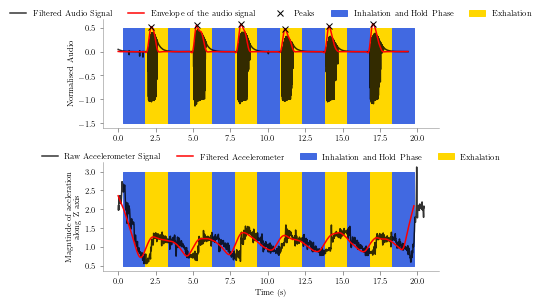

In [4]:

lt.latexify(columns=2)
fig, ax = plt.subplots(2,1, sharex=True)
timeInSeconds = 20
#read the audio data
tidal, fs = librosa.load('SpiroMask-July2021/SmartMaskData/Tidal/Cloth/Rishiraj10.Tidal_C.07.RCLB.Metronome.wav')
tidal = tidal[0:fs*timeInSeconds]
#skip some part of the signal
tidal = tidal[14000:]
tidal_t = [s/fs for s in range(0,len(tidal))]

#read the IMU data
df = pd.read_csv("SpiroMask-July2021/chestBandData/Rishiraj10.Metronome1.csv")

#skip some part of the signal
df = df.iloc[90:,:]


sr=100
df['Time'] = [s/sr for s in range(0,df.shape[0])]
print("IMU Signal is {} seconds long".format(df.shape[0]/sr))


#filtering audio using band passfilter
cutoff_low = 100 
cutoff_high = 1200
order = 5
fs = 16000
tidal_f = butter_bandpass_filter(tidal,cutoff_low,cutoff_high,fs,order)
#apply hilbert transform
x_filt_hilbert = signal.hilbert(tidal_f)
envelope_hat = np.abs(x_filt_hilbert)
#filter the Hilbert envelope
nyq_rate = fs /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt = signal.filtfilt(taps, 1,envelope_hat)
peaks_tidal,_ = find_peaks(envelope_hat_filt, height=0.15)
peaks_tidal_n,_ = find_peaks(-envelope_hat_filt)


#filtering the IMU data
size = 70
window = np.ones(size)/size
#window = scipy.signal.gaussian(M=size, std=6)
filteredA = np.convolve(df['Z'], window, mode='valid')
#filteredHP = df['Z']
filteredHP = filteredA
x_filt_hilbert_imu = signal.hilbert(filteredHP)
envelope_hat_imu = np.abs(x_filt_hilbert_imu)
#filter the Hilbert envelope
nyq_rate = sr /0.5
width = 1.0/nyq_rate # 5 Hz filter transition width.
ripple_db = 10.0 # stop band attenuation
fL_hz = 10
N, beta = signal.kaiserord(ripple_db, width)
taps = signal.firwin(N, fL_hz/nyq_rate, window=('kaiser', beta))
envelope_hat_filt_imu = signal.filtfilt(taps, 1,envelope_hat_imu)

#make the plots
ax[0].plot(tidal_t,tidal, 'black', alpha=0.8)
#ax[0].plot(tidal_t,tidal_f, 'b', alpha=0.2)
ax[0].plot(tidal_t,envelope_hat_filt,'r');
ax[0].plot([tidal_t[i] for i in peaks_tidal], [envelope_hat_filt[i] for i in peaks_tidal], "x", color='black')
#ax[0].plot([tidal_t[i] for i in peaks_tidal_n], [envelope_hat_filt[i] for i in peaks_tidal_n], "x", color='orange')

i=0.3;i_t = True
while(i<18.5):
    if i_t == True:
        ax[0].fill_between([i,i+1.5], -1.5,0.50, color='royalblue')
        i+=1.5
        i_t = False
    else:
        ax[0].fill_between([i,i+1.5], -1.5,0.50, color='gold')
        i+=1.5
        i_t = True
    

ax[0].legend(['Filtered Audio Signal', 'Envelope of the audio signal','Peaks','Inhalation and Hold Phase', 'Exhalation'], ncol=6, loc='upper center', frameon=False, bbox_to_anchor =(0.50, 1.15))
ax[0].set_ylabel('Normalised Audio')
#ax[1].plot(df['Time'][69:],envelope_hat_filt_imu,'r')

ax[1].plot(df['Time'],df['Z'],'k', alpha=0.8)
ax[1].plot(df['Time'][:-(size-1)],envelope_hat_filt_imu,'r')
ax[1].set_ylabel('Magntiude of accleration\n along Z axis')
ax[1].set_xlabel('Time (s)')



peaks_imu_,_ = find_peaks(envelope_hat_filt_imu)
peaks_imu_n,_ = find_peaks(-envelope_hat_filt_imu)

#ax[1].plot(df['Time'][peaks_imu_], [envelope_hat_filt_imu[i] for i in peaks_imu_], "x", color='black')


i=0.3;i_t = True
while(i<18.5):
    if i_t == True:
        ax[1].fill_between([i,i+1.5], 0.50,3.00, color='royalblue')
        i+=1.5
        i_t = False
    else:
        ax[1].fill_between([i,i+1.5], 0.50,3.00, color='gold')
        i+=1.5
        i_t = True

ax[1].legend(['Raw Accelerometer Signal', 'Filtered Accelerometer','Inhalation and Hold Phase', 'Exhalation'], ncol=6, loc='upper center', frameon=False, bbox_to_anchor =(0.50, 1.15))
lt.format_axes(ax[0])
lt.format_axes(ax[1])
fig.tight_layout();
plt.savefig('tidal.pdf', bbox_inches='tight')

In [24]:
#Lets estimate the tI and tE from first 5 breathing cycles.
tI  = np.mean((peaks_imu_[1:6] - peaks_imu_n[:5])/100)
print("Average Inhalation Time From IMU Data = {:.2f} seconds".format(tI))
tE = np.mean((peaks_imu_n[0:6] - peaks_imu_[0:6])/100)
print("Average Exhalation Time From IMU Data = {:.2f} seconds".format(tE))

Average Inhalation Time From IMU Data = 1.09 seconds
Average Exhalation Time From IMU Data = 1.84 seconds


In [14]:
#Lets estimate the tI and tE from audio samples.
trPoint = []
for i in peaks_tidal:
    #find the number just before the number greater then i
    for j in range(0,len(peaks_tidal_n)):
        if peaks_tidal_n[j]>i:
            trPoint.append(peaks_tidal_n[j-1])
            break;
            
nextPoint = []
for i in peaks_tidal:
    #find the number just before the number greater then i
    for j in range(0,len(peaks_tidal_n)):
        if peaks_tidal_n[j]>i:
            nextPoint.append(peaks_tidal_n[j])
            break;

tI_a  = np.mean((peaks_tidal[1:] - trPoint[1:])/16000)
tE_a = np.mean((nextPoint - peaks_tidal)/16000)
print("Average Inhalation Time From Audio Data = {:.2f} seconds".format(tI_a))
print("Average Exhalation Time From Audio Data = {:.2f} seconds".format(tE_a))

Average Inhalation Time From Audio Data = 0.48 seconds
Average Exhalation Time From Audio Data = 0.89 seconds


### One to one comparison of 40BPM (13 BP20S) Metronome with audio and IMU signal
#### Inhale is first beat. Second Beat is hold. Third beat is exhale

In [29]:
#Lets estimate the tI and tE from first 5 breathing cycles.
tI  = np.mean((peaks_imu_[:5] - peaks_imu_n[:5])/100)
print("Average Inhalation Time From IMU Data = {:.2f} seconds".format(tI))
tE = np.mean((peaks_imu_n[1:5] - peaks_imu_[:4])/100)
print("Average Exhalation Time From IMU Data = {:.2f} seconds".format(tE))

Average Inhalation Time From IMU Data = 1.69 seconds
Average Exhalation Time From IMU Data = 1.43 seconds
